# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import functools
import matplotlib.pyplot as plt
import seaborn as sb
import scanpy as sc
import spatialdata
import spatialdata_io as sdio
import numpy as np
import pandas as pd
import corescpy as cr

ModuleNotFoundError: No module named 'spatialdata'

# Setup

## Options & Data

In [21]:
%%time

# Count Threshold for Cell Quantification
count_threshold = 1

# File Paths
libid = "Inflamed-50006A"
# libid = "Uninflamed-50336C"
# libid = "Stricture-50564A4"
dir_data = "/mnt/cho_lab/bbdata2/outputs/TUQ97N"
out_dir = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
              "outputs/TUQ97N/nebraska")
path_dir = os.path.join(out_dir, "pathology")
file_align = os.path.join(path_dir,
                          f"alignment/{libid}_alignment_files/matrix.csv")
file_image = (os.path.join(path_dir, f"{libid.split('-')[1]}.ndpi"),  # raw
              os.path.join(path_dir, f"ome-tiff/{libid}.ome.tif"))  # convert

# Clustering Version
col_cell_type = "leiden_res1pt5_dist0_npc30"  # high resolution
# c_t = "leiden_res0pt75_dist0pt3_npc30"  # medium resolution
# c_t = "leiden_res0pt5_dist0pt5_npc30"  # low resolution

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

# Spatial Data
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])
file_path = np.array(files)[np.where(["-".join(libid.split(
    "-")[1:]) == os.path.basename(x).split("__")[2].split(
        "-")[0] for x in files])[0][0]]
self = cr.Spatial(os.path.join(dir_data, file_path), library_id=libid,
                  col_cell_type=col_cell_type, n_jobs=16)
self.update_from_h5ad(os.path.join(out_dir, libid + ".h5ad"))
self.get_layer("counts", inplace=True)
self.adata

NameError: name 'cr' is not defined

## Load Annotations

In [ ]:
fmr = os.path.join(out_dir, "annotation_dictionaries", str(
    f"{self._library_id}___{col_cell_type}_dictionary.xlsx"))  # file
fmr = pd.read_excel(fmr).astype(str)
c_m = col_cell_type.split("leiden_")[1]
for x in ["annotation", "bin", "bucket"]:
    self.rna.obs.loc[:, f"{x}_{c_m}"] = self.rna.obs[col_cell_type].astype(
        int).astype(str).replace(fmr.set_index(fmr.columns[0])[x])  # to label
    self.rna.obs.loc[:, f"{x}_{c_m}"] = self.rna.obs[
        f"{x}_{c_m}"].astype("category")  # as categorical

## Load Image

If you haven't already, add the `bfconvert` command-line tool (https://docs.openmicroscopy.org/bio-formats/5.7.1/users/comlinetools/index.html) to your path. For instance, if the tool is stored in `/opt`:

`echo 'export PATH="$PATH:/opt/bftools/"" >> ~/.bashrc`.

In [ ]:
if os.path.exists(file_image[1]) is False:  # convert to ome-tiff if needed
    cr.tl.write_ome_tif(file_image[0], file_image[1], bf_cmd="bfconvert")
self.add_image(file_image[1], name="he", file_align=file_align)  # add image

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from napari_spatialdata import Interactive
# from spatialdata import SpatialData

# plt.rcParams["figure.figsize"] = (20, 20)

# sdata = self.adata
# interactive = Interactive(sdata)
# interactive.run()

# Render Images

In [ ]:
%%time

axes = plt.subplots(1, 2, figsize=(20, 13))[1].flatten()
# axes = plt.subplots(3, 1, figsize=(20, 13))[1].flatten()
self.adata.pl.render_images("he").pl.show(
    ax=axes[0], title="H&E", coordinate_systems="global")
self.adata.pl.render_images("morphology_focus").pl.show(
    ax=axes[1], title="Morphology", coordinate_systems="global")
# self.adata.pl.render_shapes(color=col_cell_type).pl.show(
#     ax=axes[2], title="Labels", coordinate_systems="global")

In [ ]:
self.adata.pl.render_images("morphology_focus").pl.show(
    title="Morphology", coordinate_systems="global", dpi=20)
self.adata.pl.render_shapes(elements="cell_boundaries", groups=[
    "1", "2"], color=col_cell_type).pl.show(coordinate_systems="global")

In [ ]:
axes = plt.subplots(1, 2, figsize=(30, 30))[1].flatten()
self.adata.pl.render_images("he").pl.show(
    ax=axes[0], title="H&E", coordinate_systems="global")
self.adata.pl.render_shapes(color=col_cell_type).pl.show(
    ax=axes[1], title="Labels", coordinate_systems="global")

In [ ]:
sdata = self.crop([800, 1000], [600, 800])

In [ ]:
sdata.pl.render_images("morphology_focus", scale="scale4").pl.show(
    title="Morphology", coordinate_systems="global")

In [ ]:
%%time

from spatialdata_io.experimental import to_legacy_anndata

adata = to_legacy_anndata(self.adata, include_images=True,
                          coordinate_system="transformed")
sc.pl.spatial(adata, library_id="morphology_focus", img_key="hires",
              na_color="white", show=True, crop_coord=(0, 2000, 0, 2000))

# Image Analysis

In [ ]:
# Directories & Metadata
load, reannotate = True, True
# run = "CHO-011"
# samples = "all"
run = None  # just look for samples in all runs
# samples = ["50452A", "50452B", "50006A", "50006B",
#            "50217A", "50217B", "50336B", "50336C"]  # paired (un)inflamed
# samples = ["50006B", "50006A",  "50006C",
#            "50217B", "50217A", "50217C",
#            "50564A4",
#            "50452A", "50452B", "50452C",
#            "50336C", "50336B",  "50336A"]  # all
samples = ["50006C", "50217C", "50452C", "50336A"]  # paired strictures


# Optionally, Define Manual Annotation Versions
# should be stored in ("<out_dir>/annotations_dictionaries")
# in format <selves[i]._library_id>___leiden_<man_anns[i]>_dictionary.xlsx
# with first column = leiden cluster and second column = annotation
man_anns = True  # load manual annotations according to clustering kws
# man_anns = ["res0pt5_dist0pt5_npc30", "res0pt75_dist0pt3_npc30",
#             "res1pt5_dist0_npc30"]  # choose manual annotations to load
# man_anns = None  # do not load manual annotations

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)


In [ ]:
for g in genes:
    sc.queries.enrich(adata, g)


# Workspace

## STLearn

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import warnings
import functools
import stlearn as st
import scanpy as sc
from dask_image.imread import imread
import imagecodecs
from PIL import Image
import dask.array as da
import squidpy as sq
import pandas as pd
import numpy as np

warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500




In [2]:
# File Paths & Options
SPATIAL_KEY = "spatial"
library_id = "Inflamed-50452B"
dir_data = "/mnt/cho_lab/bbdata2/outputs/TUQ97N"
out_dir = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
              "outputs/TUQ97N/nebraska")
path_dir = os.path.join(out_dir, "pathology")
file_align = os.path.join(
    path_dir, f"alignment/{library_id}_alignment_files/matrix.csv")
file_image = (os.path.join(path_dir, f"{library_id.split('-')[1]}.ndpi"),
              os.path.join(path_dir, f"ome-tiff/{library_id}.ome.tif"))
image_kws = {}

# Find Files
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])
file_path = np.array(files)[np.where(["-".join(library_id.split(
    "-")[1:]) == os.path.basename(x).split("__")[2].split(
        "-")[0] for x in files])[0][0]]
img_dir = os.path.join(dir_data, file_path)
if os.path.exists(os.path.join(img_dir, "morphology_focus.ome.tif")) is False:
    img_dir = os.path.join(img_dir, "morphology_focus")

# Data
adata = sc.read(os.path.join(out_dir, f"{library_id}.h5ad"))
adata.uns[SPATIAL_KEY] = {library_id: {"images": {}}}

In [13]:
# img_files = {f for f in os.listdir(img_dir) if f.endswith("_focus.ome.tif")}
# channel_names = {0: "DAPI"} if len(img_files) == 1 else {
#     0: "DAPI", 1: "ATP1A1/CD45/E-Cadherin", 2: "18S",
#     3: "AlphaSMA/Vimentin", 4: "dummy"}
# image_kws["c_coords"] = list(channel_names.values())
# image_path = os.path.join(img_dir, "morphology_focus_{:04}.ome.tif".format(
#     0) if len(img_files) > 1 else "morphology_focus.ome.tif")
# image = imread(image_path)

# if "c_coords" in image_kws and "dummy" in image_kws["c_coords"]:
#     image = da.concatenate([image, da.zeros_like(image[0:1])], axis=0)
# adata.uns["spatial"][library_id]["images"] = {"hires": sq.im.ImageContainer(
#     image, library_id=library_id)}

# st.add.image(adata, library_id=library_id, quality=quality,
#              imgpath=image_path, scale=scale)

max_size = np.max([adata.obs["imagecol"].max(), adata.obs["imagerow"].max()])
max_size = int(max_size + 0.1 * max_size)
image = Image.new("RGBA", (max_size, max_size), (255, 255, 255, 255))
adata.uns["spatial"][library_id]["images"] = {"hires": np.array(image)}

In [4]:
col_cell_type = "leiden_res1pt5_dist0_npc30"  # high resolution
l_r = {"CSF1": "CSF1R", "CSF2": ["CSF2RA", "CSF2RB"]}
plot_lr = ["CSF1_CSF1R", "CSF2_CSF2RA", "CSF2_CSF2RB"]

n_spots = 125
organism = "human"
resource = "connectomeDB2020_lit"
distance = 100
min_spots = 20
n_pairs = 10000  # CHANGE DEFAULT TO 10000
n_top = 50
n_jobs = 20
stats = "all"
layer = "counts"
adj_method = None
pval_adj_cutoff = None

kwargs = {}

In [5]:
# Process Arguments
if isinstance(stats, str) and stats.lower().strip() == "all":
    stats = ["lr_scores", "p_vals", "p_adjs", "-log10(p_adjs)"]
pval_adj_cutoff, pval_adj_cutoff = [kwargs.pop(x, None) for x in [
    "pval_adj_cutoff", "adj_method"]]

# Make Compatible with Hard-Coded Column in stlearn Code
# max_coor = np.max(adata.obsm["spatial"])
# scale = 2000 / max_coor
scale = kwargs.pop("scale", 1)
quality = kwargs.pop("key_image", "hires")
spot_diameter_fullres = kwargs.pop("spot_diameter_fullres", 15)
if "spatial" in adata.obsm:
    adata.obs.loc[:, "imagerow"] = adata.obsm["spatial"][:, 0] * scale
    adata.obs.loc[:, "imagecol"] = adata.obsm["spatial"][:, 1] * scale
if "scalefactors" not in adata.uns["spatial"]:
    adata.uns["spatial"][library_id]["scalefactors"] = {}
    adata.uns["spatial"][library_id]["scalefactors"][
        "tissue_" + quality + "_scalef"] = scale
    adata.uns["spatial"][library_id]["scalefactors"][
        "spot_diameter_fullres"] = spot_diameter_fullres
    adata.uns["spatial"][library_id]["use_quality"] = "hires"

Normalization step is finished in adata.X
Gridding...


In [14]:
# Pre-Process Data
adata.X = adata.layers[layer].copy()
st.pp.normalize_total(adata)

# Create Spot Grid
grid = st.tl.cci.grid(adata, n_row=n_spots, n_col=n_spots,
                      use_label=col_cell_type)

Normalization step is finished in adata.X
Gridding...


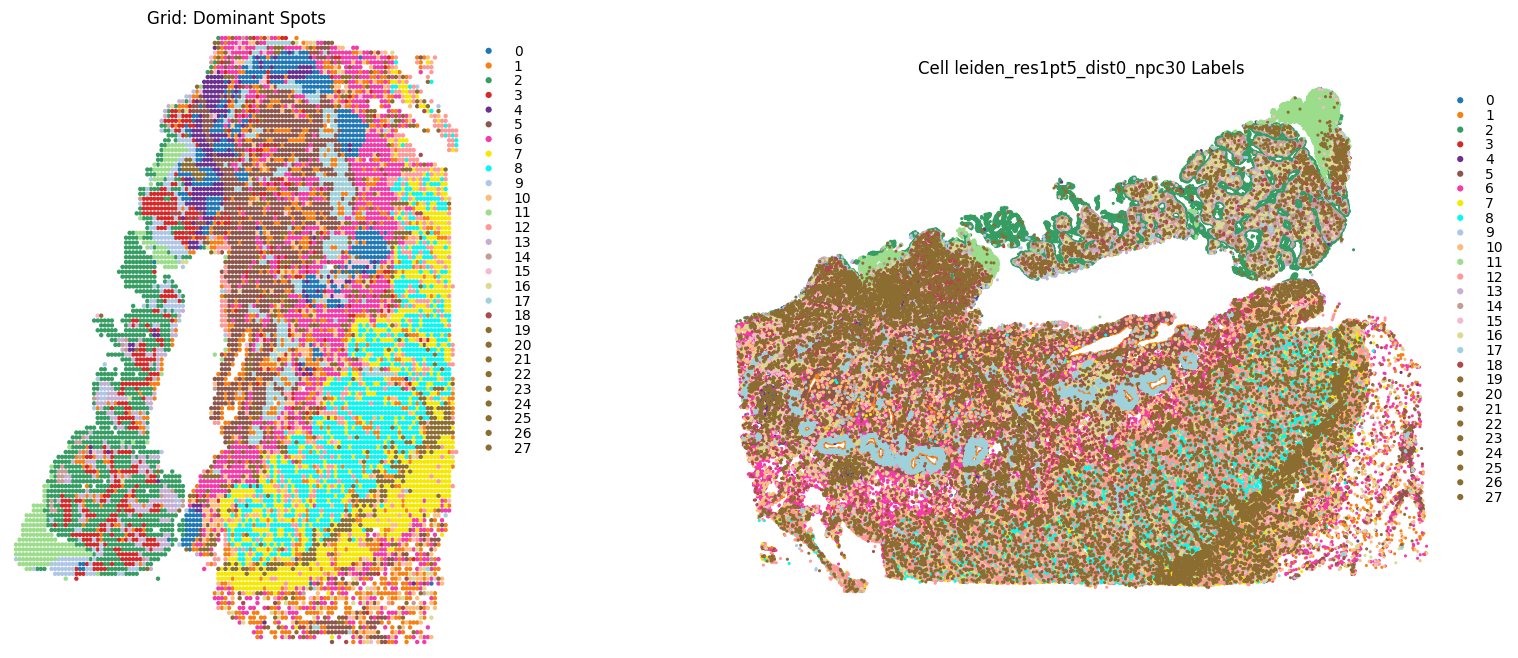

In [15]:
# Plot: Compare Clusters to Created Spots
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))
st.pl.cluster_plot(grid, use_label=col_cell_type, size=10,
                   ax=axes[0], show_plot=False)
st.pl.cluster_plot(adata, use_label=col_cell_type,
                   ax=axes[1], show_plot=False)
axes[0].set_title(f"Grid: Dominant Spots")
axes[1].set_title(f"Cell {col_cell_type} Labels")
plt.show()

In [ ]:
groups = list(grid.obs[col_cell_type].cat.categories)
for g in groups[0:2]:
    fig, axes = plt.subplots(ncols=3, figsize=(20,8))
    group_props = grid.uns[col_cell_type][g].values
    grid.obs["Group"] = group_props
    st.pl.feat_plot(grid, feature="Group", ax=axes[0], show_plot=False,
                    vmax=1, show_color_bar=False)
    st.pl.cluster_plot(grid, use_label=col_cell_type, list_clusters=[g],
                       ax=axes[1], show_plot=False)
    st.pl.cluster_plot(adata, use_label=col_cell_type, list_clusters=[g],
                       ax=axes[2], show_plot=False)
    axes[0].set_title(f"Grid {g} Proportions (Maximum = 1)")
    axes[1].set_title(f"Grid {g} Maximum Spots")
    axes[2].set_title(f"Individual Cell {g}")
    plt.show()

In [19]:
# Run Analysis
lrs = st.tl.cci.load_lrs([resource], species=organism)
st.tl.cci.run(
    grid, lrs, min_spots=min_spots, distance=distance,
    n_pairs=n_pairs, n_cpus=n_jobs)
if pval_adj_cutoff is not None or adj_method is not None:  # adjust p?
    st.tl.cci.adj_pvals(
        grid, correct_axis="spot", pval_adj_cutoff=pval_adj_cutoff,
        adj_method=adj_method)  # optionally, adjust p-values
print(grid.uns["lr_summary"])

Calculating neighbours...
12 spots with no neighbours, 4 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 22 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]


Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].
             n_spots  n_spots_sig  n_spots_sig_pval
COL1A2_CD44     9730         1255              4952
COL1A1_CD44     9731          688              3508
IL1B_IL1R2      3197          105               237
PLAU_PLAUR      6794           67               166
IL1A_IL1R2      1714           52               165
IL6_IL6ST       7745           35               752
CSF1_CSF1R      9269           14                99
IL34_CSF1R      7719           10               125
OSM_IL6ST       3368            7               137
IL11_IL6ST      2864            5               103
IFNG_IFNGR1     3699            5

'per_lr_cci_leiden_res1pt5_dist0_npc30' 

QC Plots failed


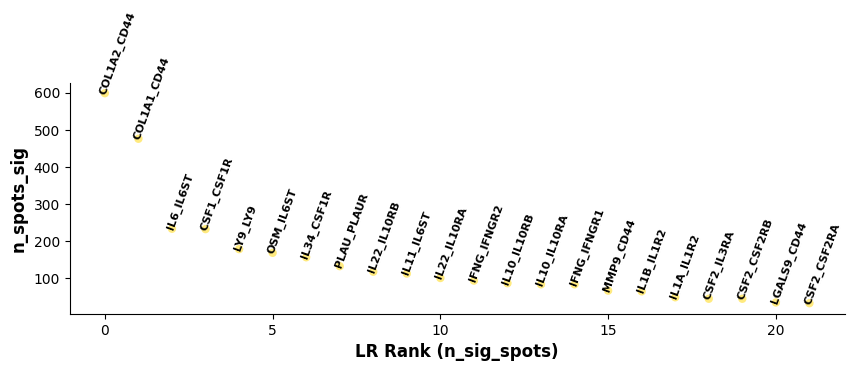

TypeError: Invalid shape (5, 54491, 39765) for image data

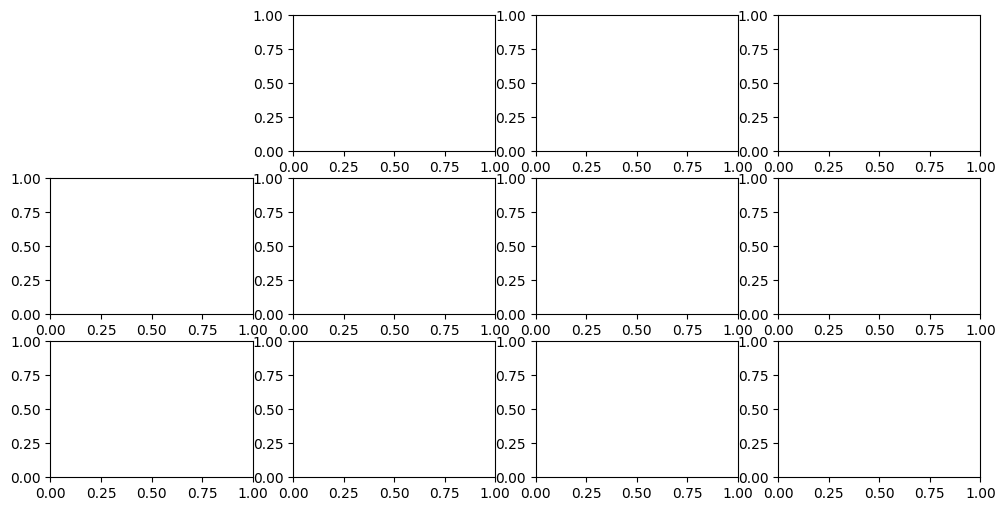

In [16]:
# QC Plots
try:
    fig, axes = st.pl.cci_check(grid, col_cell_type, figsize=(16, 5))
    fig.suptitle("CCI Check: Interactions Shouldn't Correlate Much "
                "with Cell Type Frequency if Well-Controlled for")
    st.pl.lr_diagnostics(grid, figsize=(10, 2.5))
except Exception as err:
    print(err, "\n\nQC Plots failed")

# Results Plots
st.pl.lr_summary(grid, n_top=n_top, figsize=(10, 3))  # summary plot
if plot_lr is True or isinstance(
        plot_lr, (int, float)):  # if pairs unspecified, or just want top N
    plot_lr = 3 if plot_lr is None else int(plot_lr)  # top 3 = default
    plot_lr = grid.uns["lr_summary"].index.values[:plot_lr]  # best pairs
if plot_lr not in [None, False]:  # if wanted these plots...
    fig, axes = plt.subplots(ncols=len(stats), nrows=len(plot_lr),
                             figsize=(12, 6))
    for r, x in enumerate(plot_lr):  # iterate ligand-receptors
        for c, stat in enumerate(stats):  # iterate statistics
            st.pl.lr_result_plot(grid, use_result=stat, use_lr=x,
                                 show_color_bar=False, ax=axes[r, c])
            axes[r, c].set_title(f"{x} {stat}")

TypeError: Invalid shape (5, 54491, 39765) for image data

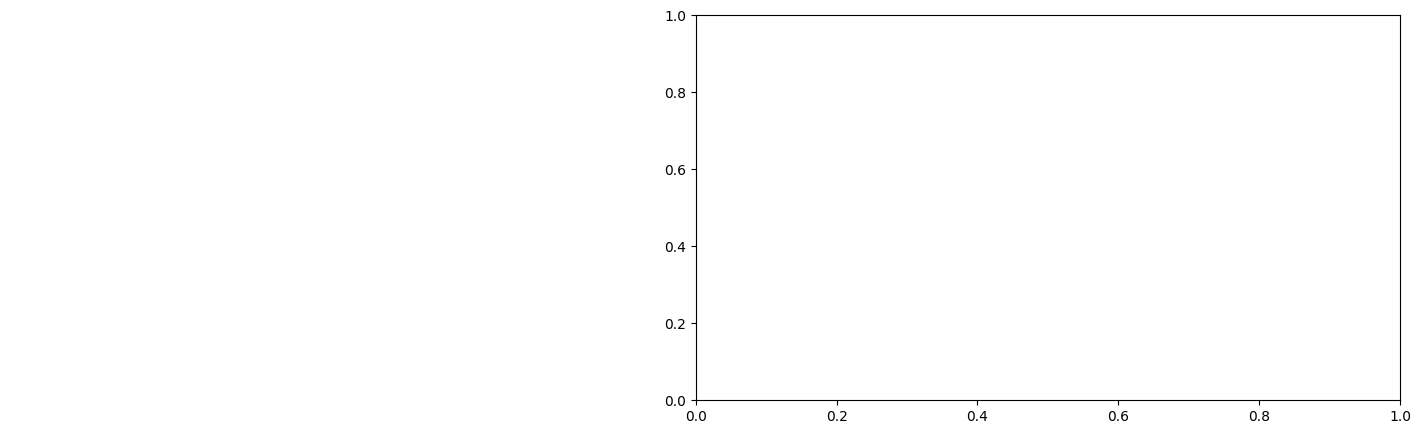

In [17]:
# Gene Expression Plots
if plot_lr is not None:
    genes = functools.reduce(lambda i, j: list(i) + list(j),
                             [i.split("_") for i in plot_lr])
    for g in genes:
        fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
        st.pl.gene_plot(grid, gene_symbols=g, ax=axes[0],
                        show_color_bar=False, show_plot=False)
        st.pl.gene_plot(adata, gene_symbols=g, ax=axes[1],
                        show_color_bar=False, show_plot=False, vmax=80)
        axes[0].set_title(f"Grid {g} Expression")
        axes[1].set_title(f"Cell {g} Expression")
        plt.show()

## Liana

In [ ]:
import liana as li
from liana.method import MistyData, genericMistyData, lrMistyData
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel
import decoupler as dc

organism = "human"
adata = sc.read(os.path.join(out_dir, libid + ".h5ad"))




adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

progeny = dc.get_progeny(organism=organism, top=500)
dc.run_mlm(mat=adata, net=progeny, source="source", target="target",
           weight="weight", verbose=True, use_raw=False)
acts_progeny = li.ut.obsm_to_adata(adata, "mlm_estimate")

adata.obsm["compositions"] =
comps = li.ut.obsm_to_adata(adata, "compositions")

misty = genericMistyData(intra=comps, extra=acts_progeny, cutoff=0.05,
                         bandwidth=200, coord_type="generic", n_rings=1)

hvg = adata.var[adata.var["highly_variable"]].index
misty(bypass_intra=True, model=LinearModel, verbose=True)


In [ ]:
ann = sc.read("kuppe_heart19.h5ad", backup_url='https://figshare.com/ndownloader/files/41501073?private_link=4744950f8768d5c8f68c')
ann.obsm["compositions"]